In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
# Load the data
df_ox = pd.read_csv('../active_learning/regression/perf_clean_run.csv', index_col=0)
df_ox.index = df_ox.SMILES

df_bor = pd.read_csv('../active_learning/regression/perf_clean_run_borylation_db0-01_a1.csv', index_col=0)
df_bor.index = df_bor.SMILES

def get_avg_vs_random(af, df, output="mean", max_=135):
    df_ = df[[af, 'random']]
    diff = []
    for i in range(len(df_)):
        if df_[af][i] == max_ and df_['random'][i] == max_: # both are not reaching the accuracy any points
            diff.append(np.nan)
        else:
            diff.append(df_['random'][i] - df_[af][i]) # both are reaching the accuracy
    if output == "median":
        return np.median(diff)
    elif output == "mean":
        return np.mean(diff)
    elif output == "diff":
        return diff

In [3]:
# make df_diffs columns of performance difference with random

def get_avg_df(df, max_):
    df_diffs = df.drop(columns=df.columns.to_list())
    for af in df.columns:
        if 'acqf' in af:
            df_diffs[af] = get_avg_vs_random(af, df, output="diff", max_=max_)
    return df_diffs

df_ox_diffs = get_avg_df(df_ox, 135)
df_bor_diffs = get_avg_df(df_bor, 60)

for af in df_ox_diffs.columns:
    df_ox_diffs[af] = df_ox_diffs[af].map(lambda x: -x)

for af in df_bor_diffs.columns:
    df_bor_diffs[af] = df_bor_diffs[af].map(lambda x: -x)

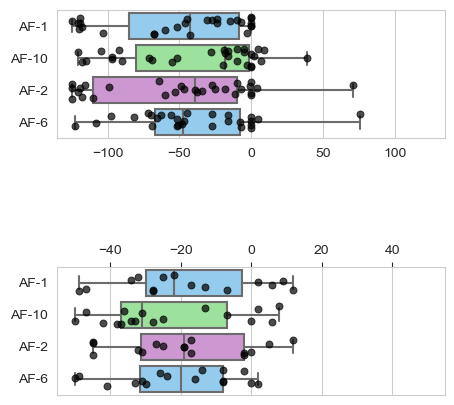

In [4]:
def get_melted(df_diffs):
    df_diffs = df_diffs.reset_index()
    melted_f = df_diffs.melt(id_vars=["SMILES"])
    melted_f['Acquisition'] = melted_f['variable'].replace({'acqf_1-db0-01-a1': 'AF-1', 
                                                            'acqf_1': 'AF-1',
                                                            'acqf_2-1': 'AF-2', 
                                                            'acqf_4-1': 'AF-4', 
                                                            'acqf_5': 'AF-5', 
                                                            'acqf_6': 'AF-6',
                                                            'acqf_10': 'AF-10'})
    melted_f = melted_f[melted_f.Acquisition.isin(['AF-1', 'AF-2', 'AF-6', 'AF-10'])]
    return melted_f

fig, ax = plt.subplots(2,1, figsize=(5,5))
custom_palette = ['lightskyblue', '#90EE90', '#D58EDB', 'lightskyblue']
melted_ox = get_melted(df_ox_diffs)
sns.boxplot(data=melted_ox, 
            x='value',
            y='Acquisition',
            palette=custom_palette,
            ax=ax[0])

sns.stripplot(data=melted_ox, 
              x='value',
              y='Acquisition',
              dodge=True,
              jitter=0.3,
              linewidth=0.7,
              color='black',
              alpha=0.7,
              #palette=custom_palette,
              legend=False,
              ax=ax[0])

ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_xlim(-135,135)

melted_bor = get_melted(df_bor_diffs)
sns.boxplot(data=melted_bor, 
            x='value',
            y='Acquisition',
            palette=custom_palette,
            ax=ax[1])

sns.stripplot(data=melted_bor, 
              x='value',
              y='Acquisition',
              dodge=True,
              jitter=0.3,
              linewidth=0.7,
              color='black',
              alpha=0.7,
              #palette=custom_palette,
              legend=False,
              ax=ax[1])

ax[1].set_xlabel("")
ax[1].xaxis.set_ticks_position('top')
ax[1].set_ylabel("")
ax[1].set_xlim(-55,55)

plt.subplots_adjust(hspace=1)

#fig.tight_layout()
fig.savefig('boxplot_acqf_clusters_2_reactions.png', dpi=600)

In [5]:
def plot_bar_af_vs_rd(df, af, head=31):
    df_ = df.copy()
    #df_.sort_values(by=af, ascending=True, inplace=True)
    df_.sort_values(by=['random', af], ascending=True, inplace=True)
    max_ = df.random.max()  
    df_ = df_.head(head)
    fig, ax =  plt.subplots(2,1, figsize=(5,2)) #figures format:plt.subplots(2,1, figsize=(5,2))
    if 'acqf_1' in af:
        custom_colors_af = ['lightskyblue' if x < max_ else 'white' for x in df_[af]]
    elif af in ['acqf_2-1', 'acqf_4-1', 'acqf_2', 'acqf_3', 'acqf_4']:
        custom_colors_af = ['#90EE90' if x < max_ else 'white' for x in df_[af]]
    else:
        custom_colors_af = ['#D58EDB' if x < max_ else 'white' for x in df_[af]]
    #custom_colors_af = ['lightskyblue' if x < max_ else 'white' for x in df_[af]]
    custom_colors_rd = ['gray' if x < max_ else 'white' for x in df_['random']]
    sns.barplot(data=df_, x='SMILES', y=af, ax=ax[1], 
                edgecolor='black',
                palette=custom_colors_af)#color='lightskyblue')
    sns.barplot(data=df_, x='SMILES', y='random', ax=ax[0],
                edgecolor='black',
                 palette=custom_colors_rd)#color='gray')
    ax[0].set_xlabel("")
    ax[1].set_xlabel("")
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[0].set_ylim(0,max_+5)
    ax[1].set_ylim(max_+5, 0)
    ax[0].set_ylabel("Random")
    ax[1].set_ylabel("AF")
    ax[0].set_title("Random (upper) vs. {} (lower)".format(af))
    plt.subplots_adjust(hspace=0.2) # figure: 0.05
    plt.show()
    return fig



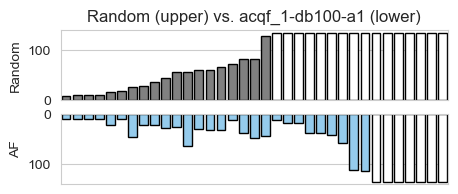

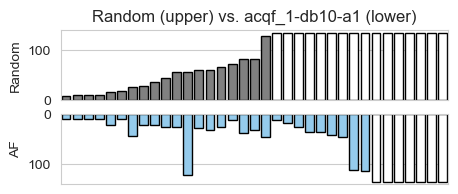

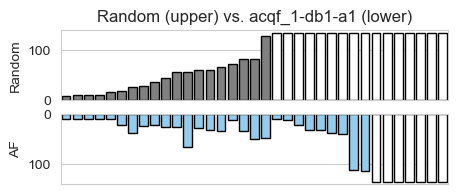

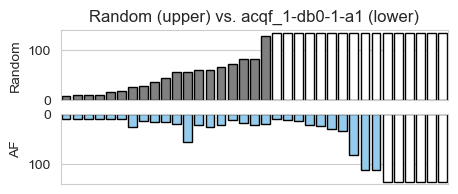

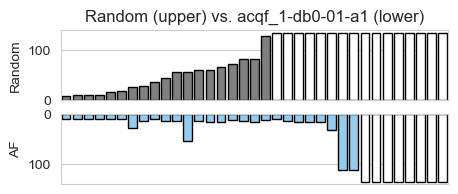

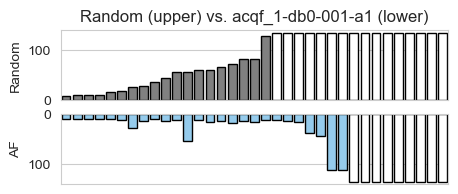

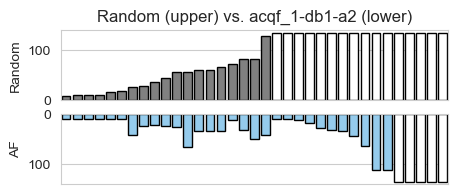

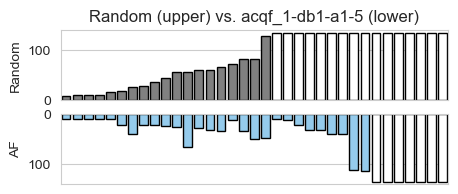

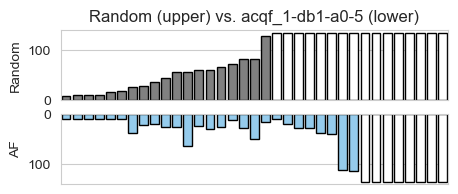

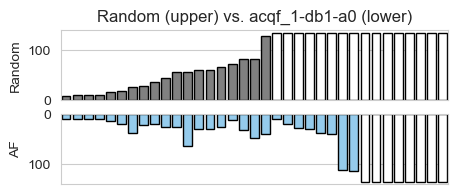

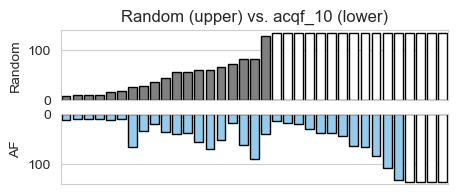

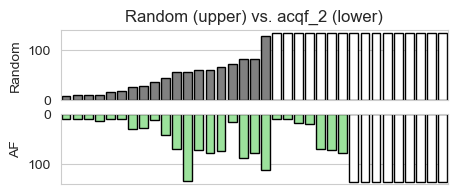

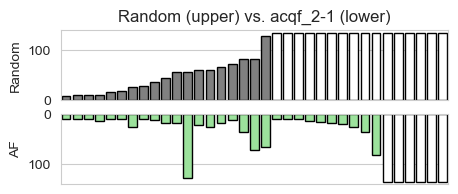

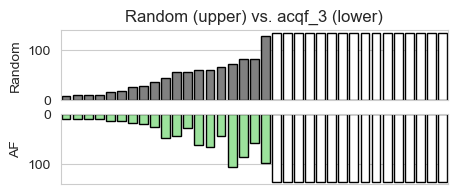

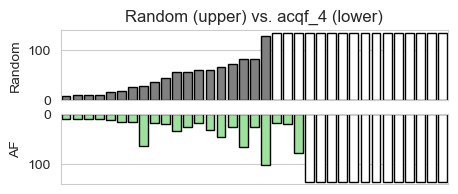

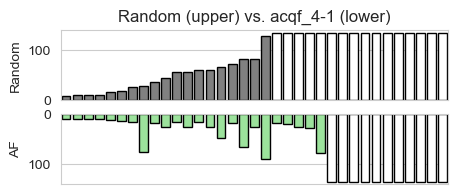

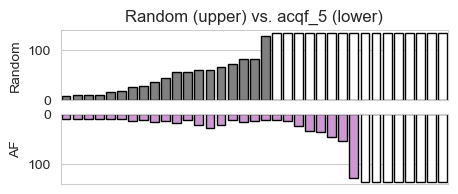

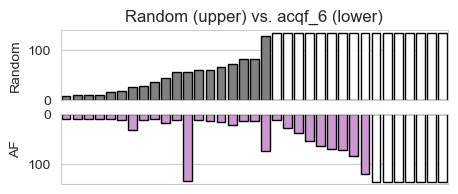

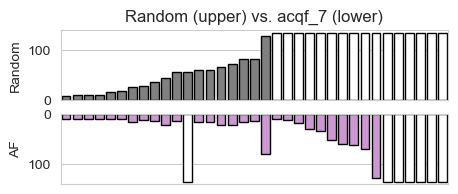

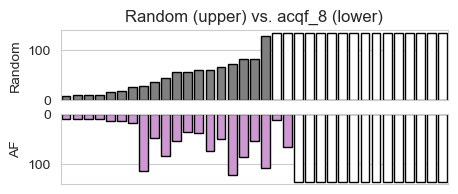

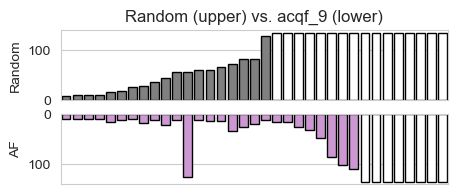

In [6]:
for af in df_ox.columns.to_list():
    if 'acqf' in af:
        fig = plot_bar_af_vs_rd(df_ox, af, head=35)
        fig.savefig(f'barplot_{af}_ox.png', dpi=300)
        plt.close()

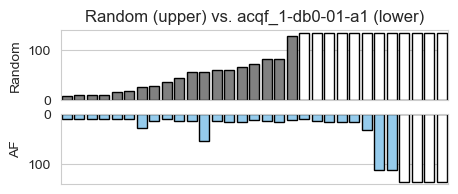

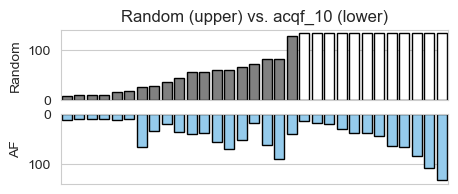

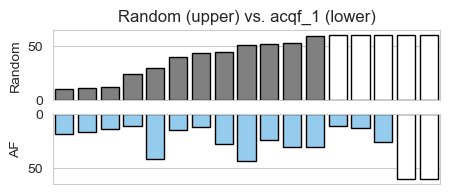

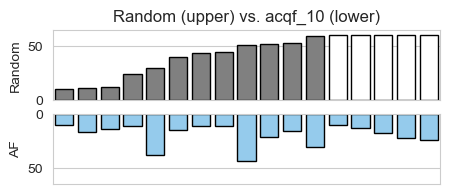

In [7]:
# bor: 'acqf_1'
fig = plot_bar_af_vs_rd(df_ox, 'acqf_1-db0-01-a1')
fig.savefig('barplot_acqf_1_vs_random_ox.png', dpi=600)
fig = plot_bar_af_vs_rd(df_ox, 'acqf_10')
fig.savefig('barplot_acqf_10_vs_random_ox.png', dpi=600)

fig = plot_bar_af_vs_rd(df_bor, 'acqf_1', head=17)
fig.savefig('barplot_acqf_1_vs_random_bor.png', dpi=600)
fig = plot_bar_af_vs_rd(df_bor, 'acqf_10', head=17)
fig.savefig('barplot_acqf_10_vs_random_bor.png', dpi=600)

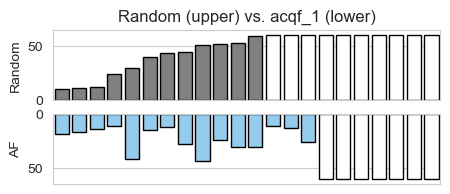

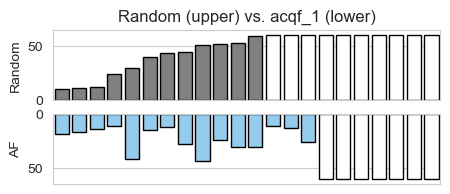

In [8]:
plot_bar_af_vs_rd(df_bor, 'acqf_1')